In [492]:
#import modules
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#get dataset, clean it up 
df = pd.read_csv('data.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [493]:
#split the dataset in training, validation and testing part
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [494]:
#calculate logarithm of target variable
#because the distribution of the target variable has a 'long tail'
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

In [495]:
#define the first numerical features
#the new training set only contains the selected base columns
#empty values are replaced with 0
#training set is transformed to matrix array with 'value' method 
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]
df_num = df_num.fillna(0)

X_train = df_num.values

In [496]:
#this function returns weights
def linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]
w_0, w = linear_regression(X_train, y_train)

#prediction of target variable, based on training set
y_pred = w_0 + X_train.dot(w)

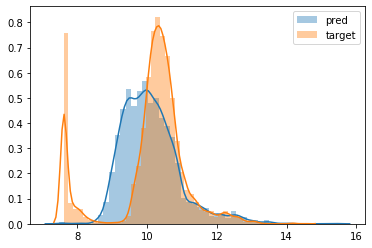

In [497]:
#the plot shows difference between distribution of 
#real target variable and predicted target variables
sns.distplot(y_pred, label='pred')
sns.distplot(y_train, label='target')
plt.legend()

In [498]:
#calculation of the root mean squared error
#based on difference between distribution of 
#real target variable and predicted target variable
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)
rmse(y_train, y_pred)

0.7554192603920132

Validating the Model

In [499]:
#create the X_val matrix array
df_num = df_val[base]
df_num = df_num.fillna(0)
X_val = df_num.values

In [500]:
#take the bias and the weights (w_0 and w), what we got from the linear regression
#and get the prediction of the target variable for the validation dataset
y_pred = w_0 + X_val.dot(w)

In [501]:
#compare y_pred with real target values 'y_val'
#that number should be used for comparing models
rmse(y_val, y_pred)

0.7616530991301601

<b>prepare_X</b> function converts dataframe in matrix (array)

In [502]:
#this function takes in feature variables (base),
#replaces empty values with 0
#and returns a matrix array with 'values'
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [503]:
#train the model by calculating the weights
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

#apply model to validation dataset
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

#compute RMSE on validation dataset
print('validation:', rmse(y_val, y_pred))

validation: 0.7616530991301601


Feature engineering: Add more features to the model<br>
we use the validation framework to see whether more features improve the model

In [504]:
#df was created in 2017
df_train.year.max()

2017

In [505]:
#write a new column 'age' to the df_train
df_train['age'] = 2017 - df_train.year

In [506]:
#use prepare_X function to add 'age' feature 
def prepare_X(df):
    #create a copy to prevent side effects
    df = df.copy()
    #create copy of base list with basic features
    features = base.copy()
    
    #compute age feature and add it to features list
    df['age'] = 2017 - df.year
    features.append('age')
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X
    
    

In [507]:
#check if adding the feature 'age' can improve the model
#train the model
#within the 'prepare_X' function, we use df_train as an argument
#within the 'prepare_X' function, we include 'age' in the features
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

#apply model to validation dataset
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

#compute RMSE on validation dataset
print('validation:', rmse(y_val, y_pred))

validation: 0.5172055461058335


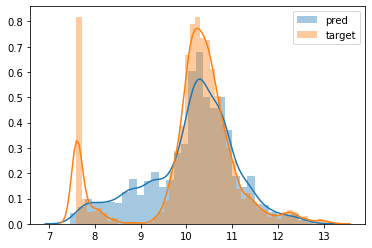

In [508]:
#plot the distributions of the real target variable (target)
#and the predicted target variable (pred)
#after whe included 'age' to the features
sns.distplot(y_pred, label='pred')
sns.distplot(y_val, label='target')
plt.legend()

Categorical Variables

In [509]:
#make use of the one-hot encoding for number of doors feature
#make use of the one-hot encoding for make feature
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        #give a feature a useful name, e.g. 'num_doors_2' for v = 2
        feature = 'num_doors_%s' % v 
        #create one-hot encoding feature
        #here a new pandas series is created (number_of_doors) (actually 3; for v=2,3,4)
        #astype(int) gives a 1 for True and a 0 for False
        value = (df['number_of_doors'] == v).astype(int)
        #add the feature back to the df, using the feature name
        df[feature] = value
        features.append(feature)
        
    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [510]:
#can we improve the RMSE of the model if we add 
#2 categorical variables to the feature set?
X_train = prepare_X(df_train)
w_0 , w = linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 0.5076038849557034


In [511]:
#function that creates the base lists of totally 7 categorical variables
#that should be considered as feature variables
#these categorical variables have different values
#we use list_length as an argument of this function in order to determine
#how many values we want to consider during the training of the model
def base_maker(list_length):
    base_02 = df['make'].value_counts()[:list_length].index.tolist()
    base_03 = df['engine_fuel_type'].value_counts()[:list_length].index.tolist()
    base_04 = df['transmission_type'].value_counts()[:list_length].index.tolist()
    base_05 = df['driven_wheels'].value_counts()[:list_length].index.tolist()
    base_06 = df['market_category'].value_counts()[:list_length].index.tolist()
    base_07 = df['vehicle_size'].value_counts()[:list_length].index.tolist()
    base_08 = df['vehicle_style'].value_counts()[:list_length].index.tolist()
    return base_02, base_03, base_04, base_05, base_06, base_07, base_08

In [512]:
#num doors is the first categorical variable, that we consider as a feature variable
#we don't include it in the base_maker function, because it would throw an error
#if we would set 'list_length' to a value bigger than 3
base_01 = df['number_of_doors'].value_counts()[:3].index.tolist()
base_01

[4.0, 2.0, 3.0]

In [513]:
#add the above categorical variables to the feature list (on top of the
#already existing features (such as the numerical variables, age and number of doors))
#we can change the value of 'list_length_val' and determine the number of values
#of the categorical variables
def prepare_X(df):
    list_length_val = 9
    df = df.copy()
    features = base.copy()
    df['age'] = 2017 - df.year
    features.append('age')
    
    #number of doors
    for v in base_01:
        feature = 'num_doors_%s' % v 
        value = (df['number_of_doors'] == v).astype(int)
        df[feature] = value
        features.append(feature)
    
    #car make
    for v in base_maker(list_length_val)[0]:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
    
    #type
    for v in base_maker(list_length_val)[1]: #A
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
    
    #transmission
    for v in base_maker(list_length_val)[2]: #B
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)
    
    #number of driven wheels
    for v in base_maker(list_length_val)[3]: #C
        feature = 'is_driven_wheels_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)
    
    #market category
    for v in base_maker(list_length_val)[4]: #D
        feature = 'is_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)
    
    #size
    for v in base_maker(list_length_val)[5]: #E
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)
    
    #style
    for v in base_maker(list_length_val)[6]: #F
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [514]:
#can we improve the RMSE of the model?
#in fact: no
X_train = prepare_X(df_train)
w_0 , w = linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 247.84099490057054


What is the reason for this huge rmse?<br>
Take a look at the normal equation:<br>
<img src="2-weight-calculation.png" width=200 align="left"><br><br><br><br>
* one issue: inversion of he matrix (XTX)-1<br>
* --> we could get a singular matrix, when we add a column, that is a combination 
of other columns
* in addition, the data is often 'noisy' (has errors, numerical instability issues)
* solution: regularization (controlling of the weights)

The new linear regression with regularization is called:<br>
<b>Ridge Regression</b><br>
<img src="4-ridge.png" width=200 align="left"><br><br><br>
* I is a matrix with 1 on the diagonal and zeros everywhere else
* alpha is a number
* this adds alpha to all diagonal elements of XTX
* in python: XTX = XTX + 0.01 * np.eye(XTX.shape[0])





In [515]:
#regularize with the parameter r
def linear_regression_reg(X, y, r=0.01):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    #add r to main diagonal of XTX
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]
    

In [516]:
# the bigger r (alpha), the smaller the weights (the denominator (Nenner) becomes bigger)
# on the left 'column', you can see r, that growths with each step
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[13], w[21]))

    0, -4790972080001581.00, -10.05, 8157.85
0.001, 6.19, -0.17, -0.64
 0.01, 6.15, -0.17, -0.58
  0.1, 5.91, -0.17, -0.28
    1, 5.31, -0.17, 0.03
   10, 4.21, -0.15, 0.19


In [517]:
# what about our RMSE
X_train = prepare_X(df_train)
w_0, w = linear_regression_reg(X_train, y_train, r=0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

print('validation:', rmse(y_val, y_pred))

validation: 0.44503301350166263


In [518]:
#run a grid search to identify the best value of r
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

 1e-06 0.44503906795361975
0.0001 0.4450371779542024
 0.001 0.44503301350166263
  0.01 0.4449993015660045
   0.1 0.4449565176268307
     1 0.44572564331770254
     5 0.4503942639682826
    10 0.45795381120569184


In [519]:
#let's take the model with r=0.01
#check it against test dataset to see if model works
X_train = prepare_X(df_train)
w_0, w = linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 0.4449993015660045
test: 0.4403028634315108


Now we can help the user to predict the price of a car

In [520]:
#the user posts an ad with the following car specifications 
#on the web site
ad = {
    'city_mpg': 18,
    'driven_wheels': 'all_wheel_drive',
    'engine_cylinders': 6.0,
    'engine_fuel_type': 'regular_unleaded',
    'engine_hp': 268.0,
    'highway_mpg': 25,
    'make': 'toyota',
    'market_category': 'crossover,performance',
    'model': 'venza',
    'number_of_doors': 4.0,
    'popularity': 2031,
    'transmission_type': 'automatic',
    'vehicle_size': 'midsize',
    'vehicle_style': 'wagon',
    'year': 2014
}

In [521]:
#dt_test is a dataframe with one row (contains the above dictionary info)
df_test = pd.DataFrame([ad])
#transformation of df to an array matrix
X_test = prepare_X(df_test)

In [522]:
#prediction of the price
y_pred = w_0 + X_test.dot(w)
#undo logarithm with exponent function
suggestion = np.expm1(y_pred)
suggestion

array([35023.40961271])

In [523]:
#find indices in df, where car (that really exist) hav specific features
#and get the real prices for comparison
ind_list = df.index[(df['city_mpg']==18) & 
         (df['driven_wheels']=='all_wheel_drive') &
         (df['engine_cylinders']==6.0) &
         (df['engine_fuel_type']=='regular_unleaded') &
         (df['engine_hp']==268.0) &
         (df['highway_mpg']==25) &
         (df['make']=='toyota') &
         (df['market_category']=='crossover,performance') &
         (df['model']=='venza') &
         (df['number_of_doors']== 4.0) &
         (df['popularity']== 2031) &
         (df['transmission_type']== 'automatic') &
         (df['vehicle_size']== 'midsize') &
         (df['vehicle_style']== 'wagon') &
         (df['year']== 2014)].tolist()
df.loc[ind_list].msrp

11279    39570
11282    35080
11283    31220
Name: msrp, dtype: int64